In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
def entropy(y, y_):
    return -(y * np.log(y_) + (1 - y) * np.log(1 - y_)).mean()

def entropy_derivative(y, y_):
    # -((y / _o) + (y - 1) / (_o - 1))
    return -((y / y_) + (y - 1) / (y_ - 1))

def relu(x, threshold=0):
    return np.maximum(x, threshold)  # Обрезаем все отрицательные значения (делаем их равными нулю)

def relu_derivative(x):
    return (x > 0).astype('int')  # 0 или 1. 1 если x больше 0

def logit(y):
    return np.log(y / (1 - y))

def logit_derivative(y):
    return 1 / y + 1 / (1 - y)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    #  Производня для сигмойда
    sig = sigmoid(x)
    return sig * (1 - sig)

def mse(y_true, y_predict):
    return np.mean((y_true - y_predict) ** 2)

In [3]:
class BinaryIterator:
    def __init__(self, name, max_count=500, batch_size=1):
        self.name = name
        self._X = []
        self._y = []
        self._max_count = max_count
        self._batch_size = batch_size
        
        self.index = 0
        
        self.debug = False
    
    def __str__(self):
        return f'{self.name} [current index: {self.index}]'
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self._max_count:
            raise StopIteration
        
        cnt = min(self._batch_size, self._max_count - self.index)
        self._extend(self.index + cnt - 1)
        
        self.index += cnt
        if self.debug:
            print(self.index, cnt)

        X = np.array(self._X[self.index - cnt:self.index])
        y = np.array(self._y[self.index - cnt:self.index]).reshape((cnt, 1))
        return X, y
    
    def _extend(self, index):
        if index >= self._max_count:
            raise StopIteration
        
        if index > len(self._X) - 1:
            cnt = index + 1 - len(self._X)
            x = np.random.randint(0, 2, 2 * cnt).reshape((cnt, 2))

            self._X.extend(x.tolist())
            self._y.extend((x[:, 0] ^ x[:, 1]).tolist())
    
    def __getitem__(self, index):
        self._extend(index)
        return np.array(self._X[index]).reshape((1, 2)), np.array(self._y[index]).reshape(1, 1)
    
    def __len__(self):
        return self._max_count // self._batch_size
    
    def drop(self):
        self.index = 0
    
    def on_epoch_end(self):
        print('on_epoch_end')
        self.drop()

In [4]:
bi_train = BinaryIterator('Binary train iterator', max_count=5, batch_size=2)
# bi_train[2]
print(next(bi_train))
# bi_train.drop()
next(bi_train)
next(bi_train)

(array([[0, 1],
       [0, 1]]), array([[1],
       [1]]))


(array([[0, 0]]), array([[0]]))

![title](mse_differential.png)

In [98]:
class NeuralNetwork:
    def __init__(self, loss=None):
        self.w1 = np.random.rand(2, 2)
        self.w1b = np.random.rand(1, 2)  # bies (np.zeros((1, 3)))
        
        self.w2 = np.random.rand(2, 1)
        
        self.l1 = None
        
        self.loss_func = loss or mse
    
    @staticmethod
    def with_weights(w1, w1b, w2):
        nn = NeuralNetwork()
        nn.w1 = w1
        nn.w1b = w1b
        nn.w2 = w2
        return nn

    def _feedforward(self, X):
        self.l1 = relu(np.dot(X, self.w1) + self.w1b)
        output = np.dot(self.l1, self.w2)
        return output

    def _backprop(self, x, y, output):
#         coef = np.random.randint(1, 100) / 1000  # 0.005
        coef = 0.01
        derivative = 2 * (y - output)# * sigmoid_derivative(output)
        
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_w2 = np.dot(
            self.l1.T,
            derivative
        )

        d_w1b = np.dot(derivative, self.w2.T) * relu_derivative(self.l1)
        d_w1 = np.dot(
            x.T,
            np.dot(derivative, self.w2.T) * relu_derivative(self.l1)
        )

        # update the weights with the derivative (slope) of the loss function
#         print(d_w2 * coef)
        self.w2 += d_w2 * coef
        
        self.w1 += d_w1 * coef
        self.w1b += d_w1b.mean(axis=0) * coef
    
    def fit(self, iterator, epochs=5, iterator_val=None):
        scores = {}
        for epoch in range(epochs):
            epoch_name = f'Epoch {epoch}'
            scores[epoch_name] = []
            
            for i, (X, y) in enumerate(iterator):
#                 print(f'Iteration: {i}')
                _o = self._feedforward(X)
                self._backprop(X, y, _o)  # update weights
                
                score = self.loss_func(y, _o)
                scores[epoch_name].append(score)
                
                if np.isnan(score) or np.isinf(score):
                    print(y[1, 1], _o[1, 1])
                    raise Exception('Score is nan')
#                 break
            print(f'Score: {np.mean(scores[epoch_name]).round(3)}. ', end='')
            
            self.evaluate_validation(iterator_val)
            iterator.drop()
#             iterator.debug = True
            print('')
        return scores
    
    def predict(self, X):
        return self._feedforward(X)
    
    def evaluate_validation(self, iterator_val=None):
        if iterator_val is not None:
            scores = []
            for X, y in iterator_val:
                y_ = self.predict(X)
                scores.append(self.loss_func(y, y_))
            iterator_val.drop()
            print(f'Val loss: {np.mean(scores).round(3)}. ', end='')

In [99]:
# scores_list = []
# for i in range(0, 1000):
#     np.random.seed(i)
np.random.seed(11)  # bad: 8, 11, 24. Good: 6, 9, 14
BATCH_SIZE = 1

ds_train = BinaryIterator('train', max_count=200, batch_size=BATCH_SIZE)
ds_val = BinaryIterator('validation', max_count=30, batch_size=BATCH_SIZE)

nn = NeuralNetwork()
scores_by_epoch = nn.fit(ds_train, epochs=30, iterator_val=ds_val)
scores = pd.DataFrame.from_dict(scores_by_epoch)
# scores_list.append(scores[scores.columns[-1]].mean())
# _ = scores.plot.line(subplots=True, figsize=(14, 8))

Score: 0.287. Val loss: 0.252. 
Score: 0.278. Val loss: 0.247. 
Score: 0.271. Val loss: 0.245. 
Score: 0.266. Val loss: 0.244. 
Score: 0.262. Val loss: 0.245. 
Score: 0.258. Val loss: 0.246. 
Score: 0.256. Val loss: 0.248. 
Score: 0.254. Val loss: 0.251. 
Score: 0.253. Val loss: 0.253. 
Score: 0.252. Val loss: 0.254. 
Score: 0.252. Val loss: 0.256. 
Score: 0.252. Val loss: 0.257. 
Score: 0.252. Val loss: 0.258. 
Score: 0.252. Val loss: 0.258. 
Score: 0.252. Val loss: 0.259. 
Score: 0.252. Val loss: 0.259. 
Score: 0.252. Val loss: 0.259. 
Score: 0.252. Val loss: 0.259. 
Score: 0.252. Val loss: 0.259. 
Score: 0.252. Val loss: 0.259. 
Score: 0.251. Val loss: 0.259. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 
Score: 0.251. Val loss: 0.26. 


In [126]:
nn.predict(X).round(2), X[:, 0] ^ X[:, 1] 

(array([[0.54],
        [0.54],
        [0.45],
        [0.46]]),
 array([0, 1, 1, 0], dtype=int32))

In [102]:
X

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [913]:
print(relu(np.dot(X, nn.w1) + nn.w1b))
print(np.dot(relu(np.dot(X, nn.w1) + nn.w1b), nn.w2))

[[5.25091241e-16 0.00000000e+00]
 [0.00000000e+00 8.95454766e-01]
 [9.29016737e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[5.6521182e-16]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]]


In [103]:
weights_w1 = np.repeat(np.arange(-1, 1, 0.01), 4).reshape(200, 2, 2)
weights_w1b = np.repeat(np.arange(-0.5, 0, 0.01), 2).reshape(50, 1, 2)
weights_w2 = np.repeat(np.arange(0.8, 1.3, 0.01), 2).reshape(50, 2, 1)

res_weights_table = []
for i, weights_w1_el in enumerate(weights_w1):
    if i > 0 and i % 50 == 0:
        print(i)

    for weights_w1b_el in weights_w1b:
        for weights_w2_el in weights_w2:
            y = NeuralNetwork.with_weights(weights_w1_el, weights_w1b_el, weights_w2_el).predict(X)
            res_weights_table.append(
                np.hstack((
                    weights_w1_el.ravel(),
                    weights_w1b_el.ravel(),
                    weights_w2_el.ravel(),
                    mse(X[:, 0] ^ X[:, 1], y)
                ))
            )
res_weights_table = np.array(res_weights_table)
res_weights_table.shape

50
100
150


(500000, 9)

In [104]:
df_tmp = pd.DataFrame(res_weights_table, columns=list(map(lambda v: f'w-{v}', range(8))) + ['mse'])
df_tmp = df_tmp.sort_values('mse')
df_tmp.head()

,w-0,w-1,w-2,w-3,w-4,w-5,w-6,w-7,mse
304952,0.21,0.21,0.21,0.21,-0.01,-0.01,0.82,0.82,0.334722
304951,0.21,0.21,0.21,0.21,-0.01,-0.01,0.81,0.81,0.334728
304953,0.21,0.21,0.21,0.21,-0.01,-0.01,0.83,0.83,0.334766
304950,0.21,0.21,0.21,0.21,-0.01,-0.01,0.80,0.80,0.334784
307450,0.22,0.22,0.22,0.22,-0.01,-0.01,0.80,0.80,0.334784


In [105]:
z = res_weights_table[:, -1]
xy = TSNE(n_components=2).fit_transform(res_weights_table[:, :-1])
print(xy.shape)

(500000, 2)


In [995]:
X_, Y_ = np.meshgrid(xy[:, 0], xy[:, 1])
Z, _ = np.meshgrid(z, z)
X.shape, Y.shape, Z.shape

((12500, 12500), (12500, 12500), (12500, 12500))

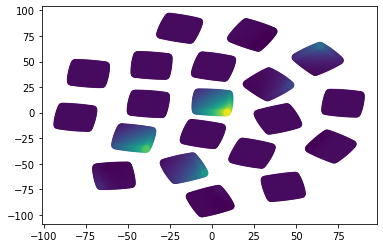

In [1014]:
color = (z - z.min()) / (z.max() - z.min())
plt.scatter(xy[:, 0], xy[:, 1], c=color, alpha=0.5)

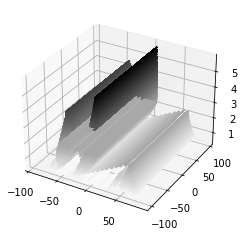

In [998]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.contour3D(X, Y, Z, 50, cmap='binary')

In [425]:
entropy(1, 0.01), entropy(1, 0.99), entropy(0, 0.01), entropy(0, 0.99)

(4.605170185988091,
 0.01005033585350145,
 0.01005033585350145,
 4.605170185988091)

Функция потери - Кросс-энтропия (Исходные формулы)

$$
L = -\frac{1}{N} \sum_{n=1}^{\infty} y_i log_2(\hat y_i) + (1 - y_i)log_2(1 - \hat y_i) - for \: one \: window \\
$$

Прямое распространение:
$$
\hat y = \sigma(W_1*x)
$$
Loss:
$$
Loss(y, \hat y) = - \frac{1}{N} \sum_{n=1}^{\infty} y_i log_2(\hat y_i) + (1 - y_i)log_2(1 - \hat y_i)
$$
Производная:
$$
\frac{\partial Loss(y, \hat y)}{\partial \hat y} = - \frac{1}{N} \sum_{n=1}^{\infty} \frac{y_i}{\hat y_i} * 1 + \frac{1 - y_i}{1 - \hat y_i} * -1  \\
\frac{\partial Loss(y, \hat y)}{\partial \hat y} = - \frac{1}{N} \sum_{n=1}^{\infty} \frac{y_i}{\hat y_i} + \frac{y_i - 1}{\hat y_i - 1}
$$

In [354]:
class DataIterator:
    def __init__(self, name, img_size=3, max_count=500):
        self.name = name
        self._img_size = img_size
        self._images = []
        self._max_count = max_count
        
        self.index = 0
    
    def __str__(self):
        return self.name
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index > self._max_count:
            raise StopIteration
        
        if self.index > len(self._images) - 1:
            img = self._generate_img()
            self._images.append(img)
        
        self.index += 1
        img = self._images[self.index - 1]
        return img, img
    
    def drop(self):
        self.index = 0
    
    def _generate_img(self):
        img = np.zeros((3, 3)).astype('float32') + .1
        if np.random.rand() > 0.5:
            img[1, 1] = 0.9  # Точка в центре
        return img

In [294]:
ds = DataIterator('train', max_count=2)
for i, img in enumerate(ds):
    print(img[0].ravel())
#     if i > 0: 
    break

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


https://www.machinelearningmastery.ru/img/0-574427-412146.png

In [447]:
def entropy(y, y_):
    print(y, y_)
    print((1 - y), 1 - y_, np.log(1 - y_))
    return -(y * np.log(y_) + (1 - y) * np.log(1 - y_)).mean()
entropy(0.9, 1.0042145)

0.9 1.0042145
0.09999999999999998 -0.00421450000000001 nan


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


nan

In [612]:
import tensorflow as tf

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="relu", name="conv"),
        tf.keras.layers.Dense(1, activation="relu", name="out"),
#         layers.Dense(3, activation="relu", name="layer2"),
#         layers.Dense(4, name="layer3"),
    ]
)
model.build((1, 10, 10, 1))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (1, 10, 10, 1)            10        
_________________________________________________________________
out (Dense)                  (1, 10, 10, 1)            2         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [558]:
class NeuralNetwork:
    def __init__(self, loss=relu, size=3):
        self._w1 = np.random.rand(size ** 2).reshape((size, size))
        self._w2 = np.random.rand(size ** 2).reshape((size, size))
        self._dence = np.random.rand()
        self._loss = loss

    def _feedforward(self, X):
        _o = np.zeros(X.shape).astype('float32') + .1
        y_ = sigmoid(np.dot(X, self._w1).mean())
        _o[1, 1] = y_  # выровнить от 0 до 1
        return _o

    def _backprop(self, X, y, _o):
        derivative_sigmoid = sigmoid_derivative(_o)
        derivative_relu = relu_derivative(_o)
        
        res1 = entropy_derivative(y, _o)
        res2 = res1# * derivative_sigmoid  # derivative_relu
        
        d_w = 0.001 * np.dot(self._w1.T, res2)
        
        self._w1 -= d_w
    
    def fit(self, iterator, epochs=5, iterator_val=None):
        scores = {}
        for epoch in range(epochs):
            scores[epoch] = []
            print(f'Epoch: {epoch}')
            
            for X, y in iterator:
                _o = self._feedforward(X)
                self._backprop(X, y, _o)  # update weights
                
                score = entropy(y, _o)
                scores[epoch].append(score)
                print(y[1, 1], round(_o[1, 1], 2), round(score, 2), np.round(self._w1.ravel(), 2))
                
                if np.isnan(score) or np.isinf(score):
                    print(y[1, 1], _o[1, 1])
                    break
#                 break
            if np.isnan(score) or np.isinf(score):
                break
            iterator.drop()
        return scores
    
    def predict(self, X):
        return self._feedforward(X)

In [559]:
np.random.seed(1)

ds_train = DataIterator('train', max_count=500)
ds_val = DataIterator('validation', max_count=100)

nn = NeuralNetwork()
scores_by_epoch = nn.fit(ds_train, epochs=2)

Epoch: 0
0.9 0.53 0.36 [0.42 0.72 0.   0.3  0.15 0.09 0.19 0.35 0.4 ]
0.1 0.52 0.37 [0.42 0.72 0.   0.31 0.15 0.1  0.19 0.35 0.4 ]
0.9 0.53 0.36 [0.42 0.73 0.01 0.31 0.15 0.1  0.19 0.35 0.4 ]
0.1 0.52 0.37 [0.42 0.73 0.01 0.31 0.16 0.1  0.19 0.35 0.4 ]
0.9 0.53 0.36 [0.43 0.73 0.01 0.31 0.16 0.1  0.19 0.35 0.4 ]
0.1 0.52 0.37 [0.43 0.73 0.01 0.32 0.16 0.11 0.19 0.35 0.4 ]
0.9 0.54 0.36 [0.43 0.73 0.01 0.32 0.16 0.11 0.19 0.35 0.4 ]
0.1 0.52 0.37 [0.43 0.74 0.01 0.32 0.17 0.11 0.19 0.35 0.4 ]
0.9 0.54 0.36 [0.43 0.74 0.02 0.32 0.17 0.11 0.2  0.35 0.41]
0.1 0.52 0.37 [0.44 0.74 0.02 0.33 0.17 0.12 0.2  0.36 0.41]
0.1 0.52 0.37 [0.44 0.74 0.02 0.33 0.17 0.12 0.2  0.36 0.41]
0.9 0.54 0.36 [0.44 0.74 0.02 0.33 0.18 0.12 0.2  0.36 0.41]
0.9 0.54 0.36 [0.44 0.74 0.02 0.33 0.18 0.12 0.2  0.36 0.41]
0.1 0.52 0.37 [0.44 0.75 0.03 0.34 0.18 0.13 0.2  0.36 0.41]
0.9 0.54 0.36 [0.45 0.75 0.03 0.34 0.18 0.13 0.2  0.36 0.41]
0.9 0.54 0.36 [0.45 0.75 0.03 0.34 0.19 0.13 0.2  0.36 0.41]
0.9 0.54 0.36 [

0.1 0.64 0.4 [2.08 2.38 1.66 2.15 2.   1.94 1.58 1.74 1.79]
0.1 0.64 0.4 [2.09 2.39 1.67 2.16 2.01 1.95 1.59 1.76 1.81]
0.9 0.76 0.33 [2.1  2.41 1.69 2.18 2.02 1.97 1.61 1.77 1.82]
0.9 0.76 0.33 [2.11 2.42 1.7  2.19 2.03 1.98 1.62 1.78 1.83]
0.9 0.76 0.33 [2.13 2.43 1.71 2.2  2.05 1.99 1.63 1.79 1.84]
0.1 0.64 0.4 [2.14 2.44 1.72 2.21 2.06 2.   1.64 1.8  1.85]
0.9 0.76 0.33 [2.15 2.45 1.73 2.23 2.07 2.02 1.65 1.81 1.86]
0.1 0.65 0.4 [2.16 2.47 1.74 2.24 2.09 2.03 1.66 1.82 1.87]
0.9 0.76 0.33 [2.17 2.48 1.76 2.25 2.1  2.04 1.67 1.83 1.88]
0.9 0.76 0.33 [2.19 2.49 1.77 2.26 2.11 2.05 1.68 1.84 1.89]
0.1 0.65 0.4 [2.2  2.5  1.78 2.28 2.12 2.07 1.7  1.86 1.91]
0.1 0.65 0.4 [2.21 2.52 1.79 2.29 2.14 2.08 1.71 1.87 1.92]
0.9 0.77 0.33 [2.22 2.53 1.81 2.3  2.15 2.09 1.72 1.88 1.93]
0.9 0.77 0.33 [2.24 2.54 1.82 2.32 2.16 2.11 1.73 1.89 1.94]
0.9 0.77 0.33 [2.25 2.55 1.83 2.33 2.17 2.12 1.74 1.9  1.95]
0.9 0.77 0.33 [2.26 2.56 1.84 2.34 2.19 2.13 1.75 1.91 1.96]
0.9 0.77 0.33 [2.27 2.57 1.86 

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [565]:
import re, json

In [591]:
# w = np.array(json.loads(re.sub(r'\s+', ', ', '[6.72 8.57 6.3  7.26 8.8  7.05 6.06 7.7  6.27]'))).reshape((3, 3))
w = np.array([2., 2., .2, 0, 10., 0, 0, 0, 10]).reshape((3, 3))
X = np.zeros((3, 3)) + 0.1
# X[1, 1] = 0.9
# np.dot(X, w)
sigmoid(np.dot(X, w).mean())

0.6913987366813323

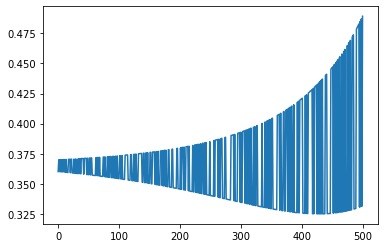

In [535]:
plt.plot(scores_by_epoch[0])

In [550]:
X = np.array([
    [0, 0, 0],
    [0, 1., 0],
    [0, 0, 0]
])
nn.predict(X)

array([[0.1, 0.1, 0.1],
       [0.1, nan, 0.1],
       [0.1, 0.1, 0.1]], dtype=float32)

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [99]:
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1", use_bias=True),
        layers.Dense(1, name="layer3", use_bias=False),
    ]
)
model.build(input_shape=(1, 2))
model.summary()

model.compile(loss='mse', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (1, 2)                    6         
_________________________________________________________________
layer3 (Dense)               (1, 1)                    2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [100]:
class KerasBinaryIterator(BinaryIterator, keras.utils.Sequence):
    def on_epoch_end(self):
        self.drop()

In [117]:
np.random.seed(6)
BATCH_SIZE = 2

ds_train = KerasBinaryIterator('train', max_count=200, batch_size=BATCH_SIZE)
ds_val = KerasBinaryIterator('validation', max_count=30, batch_size=BATCH_SIZE)

class MyCallback(keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        pass

model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=BATCH_SIZE, callbacks=[MyCallback()])

Epoch 1/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2493 - val_loss: 0.2449
Epoch 2/20
100/100 [==============================] - 0s 849us/step - loss: 0.2493 - val_loss: 0.2453
Epoch 3/20
100/100 [==============================] - 0s 884us/step - loss: 0.2496 - val_loss: 0.2452
Epoch 4/20
100/100 [==============================] - 0s 869us/step - loss: 0.2494 - val_loss: 0.2449
Epoch 5/20
100/100 [==============================] - 0s 846us/step - loss: 0.2493 - val_loss: 0.2460
Epoch 6/20
100/100 [==============================] - 0s 854us/step - loss: 0.2496 - val_loss: 0.2461
Epoch 7/20
100/100 [==============================] - 0s 847us/step - loss: 0.2494 - val_loss: 0.2466
Epoch 8/20
100/100 [==============================] - 0s 854us/step - loss: 0.2499 - val_loss: 0.2455
Epoch 9/20
100/100 [==============================] - 0s 852us/step - loss: 0.2491 - val_loss: 0.2447
Epoch 10/20
100/100 [==============================] - 0s 869us/step - loss: 0.2498 

In [674]:
model.weights

[<tf.Variable 'layer1/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[-0.97023743, -0.340518  ,  0.8038375 ],
        [ 0.95850766, -0.11108065, -1.0491995 ]], dtype=float32)>,
 <tf.Variable 'layer1/bias:0' shape=(3,) dtype=float32, numpy=array([ 0.00898145,  0.        , -0.00559647], dtype=float32)>,
 <tf.Variable 'layer3/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[1.0310452],
        [0.5349878],
        [1.2527544]], dtype=float32)>]